In [2]:
class EXP:
    MODEL = '/root/autodl-fs/hf-checkpoints/sentence-transformers/sentence-t5-base'
    # MODEL = "/root/autodl-fs/hf-checkpoints/sentence-transformers/all-mpnet-base-v2"
    DATASET = [
        "mteb/sts13-sts",
        "mteb/sts22-crosslingual-sts",
        "mteb/sts12-sts",
        "mteb/stsbenchmark-sts",
        "mteb/sickr-sts",
        "mteb/sts14-sts",
        "mteb/biosses-sts",
        "mteb/sts16-sts",
        "mteb/sts15-sts",
        "mteb/stsb_multi_mt",
        "mteb/sts17-crosslingual-sts"
    ]
    SENT_PAIR_NUM = 5
    INSERT_NUM = 1
    VERIFICATION_SENT_PAIR_NUM = 250
    target_layer = 0

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('/root/StickyToken')
import torch
import gradio as gr
import json
import pandas as pd
import random
import numpy as np
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from stickytoken.utils import load_verification_results
from collections import namedtuple
DistanceMetrics = namedtuple("Metrics", ["cosine_distance", "euclidean_distance", "manhattan_distance"])
from stickytoken.utils import distance_metrics, random_insert
from stickytoken.sentence_pair import output_dataset_name

from circuitsvis.attention import attention_patterns, attention_pattern,attention_heads
from circuitsvis.activations import text_neuron_activations
from circuitsvis.examples import hello
from circuitsvis.tokens import colored_tokens
from circuitsvis.topk_tokens import topk_tokens
from circuitsvis.topk_samples import topk_samples

In [4]:
model = SentenceTransformer(model_name_or_path=EXP.MODEL,device='cuda')
model_name =  os.path.basename(EXP.MODEL)

In [5]:
def run_with_cache(input_text: str|list[str]) -> tuple:
    """获取输入文本的注意力权重、隐状态和token字符串
    
    参数:
        input_text (str 或 list[str]): 输入文本，可以是单个字符串或字符串列表
    
    返回:
        tuple: 包含三个元素的元组
            - all_attention (tuple[torch.Tensor]): 所有注意力层的权重，每个张量形状为
              (batch_size, num_heads, seq_len, seq_len),
              例如要获取第一个句子的第一层所有头的注意力分数，可以使用：
              all_attention[0][0]  # 第一层，第一个句子
            - all_hidden_states (tuple[torch.Tensor]): 所有隐藏层的状态，每个张量形状为
              (batch_size, seq_len, hidden_size)
            - str_tokens (list[list[str]]): 转换后的token字符串列表，每个子列表对应一个输入文本的tokens
    """
    if isinstance(input_text, str):
        input_text = [input_text]  # 统一处理为列表格式
    
    # 使用tokenizer对输入文本进行预处理
    # return_tensors='pt' 返回PyTorch张量
    # add_special_tokens=True 添加特殊token如[CLS],[SEP]
    # padding=True 自动填充到相同长度
    # truncation=True 自动截断超过最大长度的文本
    inputs = model.tokenizer(
        input_text, 
        return_tensors='pt',
        add_special_tokens=True,
        padding=True,
        truncation=True
    ).to(model.device)  # 将输入数据移动到模型所在的设备（如GPU）
    
    # 禁用梯度计算以节省内存
    with torch.no_grad():
        # 通过模型前向传播获取输出
        # output_hidden_states=True 返回所有隐藏层状态
        # output_attentions=True 返回所有注意力权重
        outputs = model._first_module().auto_model(
            **inputs,
            output_hidden_states=True,
            output_attentions=True
        )
    
    # 获取所有层的注意力权重（元组结构）
    # attentions是一个元组，每个元素对应一个注意力层的输出
    # 每个元素的形状为(batch_size, num_heads, seq_len, seq_len)
    all_attention = outputs.attentions
    
    # 获取所有隐藏层的状态（元组结构）
    # hidden_states是一个元组，每个元素对应一个隐藏层的输出
    # 每个元素的形状为(batch_size, seq_len, hidden_size)
    all_hidden_states = outputs.hidden_states
    
    # 将token ids转换为可读的字符串
    # 对于每个输入文本的token ids，使用tokenizer进行转换
    # 返回一个列表，每个子列表对应一个输入文本的tokens
    str_tokens = [
        model.tokenizer.convert_ids_to_tokens(input_ids) 
        for input_ids in inputs.input_ids
    ]
    
    return all_attention, all_hidden_states, str_tokens

In [ ]:
# 测试几个例子
test_cases = [
    "The cat is sitting on the mat",
    "Natural language processing is fascinating",
    "How does attention mechanism work in transformers?",
    "This is a simple test case for attention visualization"
]

# 获取每个测试例子的注意力和tokens
for text in test_cases:
    print(f"\nTesting: {text}")
    attentions,hid, tokens = run_with_cache(text)
    print(f"Tokens: {tokens}")
    print(f"Number of attention layers: {len(attentions)}")
    print(f"Shape of first layer attention: {attentions[0].shape}")
    print(f"Shape of first layer hidden states: {hid[0].shape}")

In [7]:
from transformers import utils
from bertviz import model_view,head_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

input_text = "This is a sentence.42"
inputs = model.tokenizer(input_text, return_tensors='pt',add_special_tokens=True).to(model.device)  # 将输入文本进行标记化
with torch.no_grad():
    outputs = model._first_module().auto_model(**inputs, output_hidden_states=True, output_attentions=True)  # 生成句子嵌入并输出交叉注意力
attention = outputs.attentions
tokens = model.tokenizer.convert_ids_to_tokens(inputs.input_ids[0])  # Convert input ids to token strings

In [ ]:
outputs.last_hidden_state

In [ ]:
print(tokens)
# model_view(attention, tokens, display_mode="light")  # Display model view
head_view(attention, tokens)  # Display head view
# html_head_view = head_view(attention, tokens, html_action='return')

# with open("/root/StickyToken/notebook/head_view.html", 'w') as file:
#     file.write(html_head_view.data)

In [ ]:
model_view(attention, tokens, display_mode="light")

In [ ]:
attention[0].shape  #layer 0 attention shape

In [ ]:
attention_heads(tokens=tokens, attention=attention[0][0]) # layer 0 attention heads

In [ ]:
print("Layer 0 Head Attention Patterns:")
attention_patterns(tokens=tokens, attention=attention[0][0])

In [ ]:
attention[0][0][0]

In [15]:
# attention_pattern(tokens=tokens, attention=attention[0][0][0]) # layer 0, head 0 attention pattern

In [ ]:
values = np.random.normal(size=(len(tokens))).tolist()
print(values)
colored_tokens(tokens, values)

加载句子

In [6]:
from stickytoken.sentence_pair import SentencePair,Dataset
sent_pairs = SentencePair(EXP.DATASET,model,model_name)

文件 /root/StickyToken/data/sentence_t5_base/sentence_pairs.csv 已经存在。
sentence_pairs文件中包含 499500 个句子对。
sentence_pairs文件中包含 1000 个不重复的句子。
sentence_pairs文件中的相似度范围：最小相似度 0.47928232，最大相似度 0.9986939。
文件 /root/StickyToken/data/sentence_t5_base/sampled_sentence_pairs.csv 已经存在。
sampled_sentence_pairs文件中包含 1000 个句子对。
sampled_sentence_pairs文件中包含 773 个不重复的句子。
sampled_sentence_pairs文件中的相似度范围：最小相似度 0.47928232，最大相似度 0.9986939。


In [7]:
dataset = load_dataset('csv', data_files=sent_pairs.sampled_sentence_pairs_path, split='train')

In [8]:
sent_list = list(set(dataset['sentence1'] + dataset['sentence2']))
sent_list

['A dog, which is brown, is jumping in the air',
 'blast kills 10 young girls in eastern afghanistan',
 "i don 't know how legitimate this is , but i heard he 's kind of suicidal .",
 'A young girl in a bikini is sitting on the beach',
 'a quantity of money added to a bank account',
 'the act of distributing things into classes or categories of the same type .',
 "guatemala 's former leader found guilty of genocide",
 'take action or behave in a certain way',
 'utter in a certain way',
 'In myelopoiesis, miR-223 has been shown to regulate granulocyte development in both humans and mice.',
 'A dirty soccer ball is rolling into a goal net',
 'here is an interesting article on wikipedia to give overview of pressure related injuries .',
 'north american markets grabbed early gains monday morning , as earnings season begins to slow and economic indicators take the spotlight .',
 'to catch in or as if in a trap ; immobilize',
 'fishermen are inactive , tired and disappointed .',
 'notre dame

加载sticky和Normal token

In [9]:
import pandas as pd
def get_sticky_token_list(model_name):
    sticky_tokens_of_all_models_df = pd.read_csv("../results/final_all_models_sticky_tokens.csv")
    # 先筛选出对应模型的行
    sticky_token_column = sticky_tokens_of_all_models_df[sticky_tokens_of_all_models_df['model'] == model_name]
    # 按照main_metric从高到低排序
    sticky_token_column = sticky_token_column.sort_values(by='main_metric', ascending=False)
    # 获取排序后的raw_vocab列表
    sticky_token_list = sticky_token_column['raw_vocab'].to_list()
    return sticky_token_list

In [ ]:
sticky_token_list = get_sticky_token_list(model_name)
sticky_token_list

['</s>',
 'lucrarea',
 '▁grains',
 '▁photographed',
 '▁sportive',
 '<extra_id_18>',
 '▁brake',
 '▁organism',
 '▁br',
 '▁Gate',
 '▁Hose',
 '▁Gas',
 '▁Portable',
 '▁Patio',
 'durant',
 '▁pastel',
 '▁meme',
 '▁tip',
 '▁blanc',
 '▁joke',
 '▁Tablet']

In [11]:
from stickytoken.utils import load_vocab_token_magic_scores
def get_benign_token_list(model_name, sticky_tokens):
    vocab_token_magic_scores = load_vocab_token_magic_scores(model_name)
    vocab_token_magic_scores_df = pd.DataFrame(vocab_token_magic_scores).transpose()
    # vocab_token_magic_scores_df的'main_metric'列升序排列，取前len(sticky_tokens)*5个
    vocab_token_magic_scores_df = vocab_token_magic_scores_df.sort_values(by='main_metric', ascending=True).head(len(sticky_tokens)*4)
    # 从中随机选择len(sticky_tokens)个
    selected_tokens_df = vocab_token_magic_scores_df.sample(n=len(sticky_tokens), random_state=0)
    return selected_tokens_df['raw_vocab'].to_list()

In [12]:
benign_token_list = get_benign_token_list(model_name, sticky_token_list)
benign_token_list

['hub',
 '▁non',
 '2%',
 'einigen',
 'N',
 '3.',
 '20',
 'strict',
 'R',
 '▁percent',
 '0.00',
 '-2',
 'Ex',
 '▁distant',
 '<extra_id_1>',
 'MA',
 'AR',
 '*',
 '<unk>',
 'şi',
 'NE']

In [13]:
sticky_token_list = sticky_token_list[:2]
sticky_token_list

['</s>', 'lucrarea']

# 添加token到句子

In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import List

# 假设 model 和 run_with_cache 函数已定义
# 以下是代码实现：

def generate_augmented_sentences(
    sent_list: List[str],
    token_list: List[str],
    num_tokens: int,
) -> List[str]:
    """
    生成增强句子：在原始句子末尾插入指定数量的 token
    
    参数:
        sent_list (List[str]): 原始句子列表
        token_list (List[str]): 要插入的token列表（故障或正常）
        num_tokens (int): 插入的token数量
    返回:
        List[str]: 增强后的句子列表
    """
    augmented_sents = []
    for sent in sent_list:
        # 从token_list中随机选择num_tokens个token（允许重复）
        selected_tokens = random.choices(token_list, k=num_tokens)
        # selected_tokens = token_list[-2]
        
        # 构建增强句子：原句子 + 插入的token
        new_sent = sent  + "".join(selected_tokens)
        
        # 截断到模型最大长度（确保不超过限制）
        augmented_sents.append(new_sent)
    
    return augmented_sents

In [15]:
sticky_augmented = generate_augmented_sentences(sent_list, sticky_token_list, EXP.INSERT_NUM)
benign_augmented = generate_augmented_sentences(sent_list, benign_token_list, EXP.INSERT_NUM)
sticky_augmented[:10]

['A dog, which is brown, is jumping in the airlucrarea',
 'blast kills 10 young girls in eastern afghanistanlucrarea',
 "i don 't know how legitimate this is , but i heard he 's kind of suicidal .</s>",
 'A young girl in a bikini is sitting on the beach</s>',
 'a quantity of money added to a bank account</s>',
 'the act of distributing things into classes or categories of the same type .</s>',
 "guatemala 's former leader found guilty of genocidelucrarea",
 'take action or behave in a certain waylucrarea',
 'utter in a certain waylucrarea',
 'In myelopoiesis, miR-223 has been shown to regulate granulocyte development in both humans and mice.lucrarea']

In [16]:
print(len(sticky_augmented))
print(len(benign_augmented))

773
773


获取注意力矩阵

In [17]:
from tqdm import tqdm

# 初始化存储结果
sticky_attentions = []
sticky_all_hidden_states = []
sticky_str_tokens = []
benign_attentions = []
benign_all_hidden_states = []
benign_str_tokens = []

# 逐个处理sticky_augmented句子
for sent in tqdm(sticky_augmented, desc="Processing sticky sentences"):
    # 每次处理一个句子,获取注意力矩阵、隐藏状态和分词结果
    attentions, hidden_states, str_tokens = run_with_cache([sent])  
    sticky_attentions.append(attentions)
    sticky_all_hidden_states.append(hidden_states)
    sticky_str_tokens.append(str_tokens)

# 逐个处理benign_augmented句子
for sent in tqdm(benign_augmented, desc="Processing benign sentences"):
    # 每次处理一个句子,获取注意力矩阵、隐藏状态和分词结果
    attentions, hidden_states, str_tokens = run_with_cache([sent])
    benign_attentions.append(attentions)
    benign_all_hidden_states.append(hidden_states)
    benign_str_tokens.append(str_tokens)

Processing benign sentences: 100%|██████████| 773/773 [00:05<00:00, 147.28it/s]


In [ ]:
sticky_attentions[0][0].shape # [句子个数][layer][batch_size, num_heads, seq_len, seq_len]

In [ ]:
sticky_all_hidden_states[0][0].shape # [句子个数][layer][batch_size, seq_len, hidden_size]

In [ ]:
sum(sticky_attentions[0][0][0,0,:,-1])

## 提取感兴趣的weights

In [18]:
def extract_attention_weights(
    attentions: list,  # 修改为list类型
    str_tokens_list: List[List[str]], 
    num_inserted: int,
    layer: int = 0,
    pad_token: str = "[PAD]"  # 需根据实际tokenizer调整
) -> List[float]:
    """
    从注意力矩阵中提取插入token位置的注意力权重
    
    参数:
        attentions (list): run_with_cache返回的注意力矩阵列表
        str_tokens_list (List[List[str]]): 分词后的token列表
        num_inserted (int): 插入的token数量
        layer (int): 要分析的层（默认第0层）
        pad_token (str): 填充token的标识
    
    返回:
        List[float]: 所有插入token位置的注意力权重列表
    """
    all_weights = []
    
    # 遍历每个句子的注意力矩阵
    for sent_idx in range(len(attentions)):
        # 获取当前句子的注意力矩阵
        sent_attentions = attentions[sent_idx]
        # 获取指定层的注意力矩阵 (batch_size, num_heads, seq_len, seq_len)
        layer_attentions = sent_attentions[layer]
        batch_size, num_heads, seq_len, _ = layer_attentions.shape
        
        for i in range(batch_size):
            # 当前句子的token列表
            tokens = str_tokens_list[sent_idx][i]
            # print(tokens)
            # 找到实际非填充token的索引
            valid_indices = [idx for idx, token in enumerate(tokens) if token != pad_token]
            actual_length = len(valid_indices)
            original_length = actual_length - num_inserted
            # print(valid_indices)
            # print(original_length, actual_length)
            # 处理截断情况（如果插入的token被截断则跳过）
            if original_length < 0 or actual_length == 0:
                continue
            
            # 提取插入token的位置（original_length到actual_length-1）
            for pos in range(original_length-1, actual_length-1):
                # print(pos)
                # 遍历所有注意力头
                for head in range(num_heads):
                    # 获取该位置对所有token的注意力权重
                    # weights = layer_attentions[i, head, pos, :].tolist()
                    weights = layer_attentions[i, head, :, pos].tolist()
                    
                    # 只保留对有效token的注意力权重（过滤填充位置）
                    valid_weights = [weights[idx] for idx in valid_indices]
                    all_weights.extend(valid_weights)
    
    return all_weights # 句子数*insert_num*seq_len

In [ ]:
len(extract_attention_weights(
        sticky_attentions[:2], sticky_str_tokens, EXP.INSERT_NUM,
        layer=EXP.target_layer
    ))

In [19]:
# 3. 提取注意力权重
sticky_weights = extract_attention_weights(
        sticky_attentions, sticky_str_tokens, EXP.INSERT_NUM,
        layer=EXP.target_layer
    )
    
benign_weights = extract_attention_weights(
        benign_attentions, benign_str_tokens, EXP.INSERT_NUM,
        layer=EXP.target_layer
    )

# 4. 绘制分布图

In [29]:
def plot_distribution(
    sticky_weights: List[float],
    benign_weights: List[float],
    bins: int = 20,
    title: str = "Attention Weight Distribution"
) -> None:
    """
    绘制注意力权重分布直方图
    
    参数:
        sticky_weights (List[float]): 故障token的注意力权重
        benign_weights (List[float]): 正常token的注意力权重
        bins (int): 直方图区间数
        title (str): 图表标题
    """
    plt.figure(figsize=(7, 6))
    
    # 设置公共区间范围
    all_weights = sticky_weights + benign_weights
    range_min = min(all_weights)
    range_max = max(all_weights)
    
    # 绘制双直方图
    plt.hist(
        sticky_weights,
        bins=np.linspace(range_min, range_max, bins + 1),
        alpha=0.5,
        color="red",
        label="Sticky Tokens",
        density=True  # 显示频率而非计数
    )
    
    plt.hist(
        benign_weights,
        bins=np.linspace(range_min, range_max, bins + 1),
        alpha=0.5,
        color="blue",
        label="Benign Tokens",
        density=True
    )
    
    plt.xlabel("Attention Weight Value")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.show()


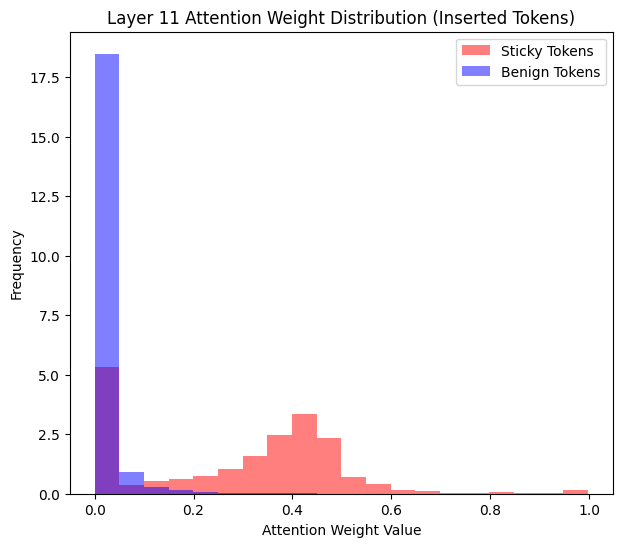

In [30]:
# 3. 提取注意力权重
target_layer = 11
sticky_weights = extract_attention_weights(
        sticky_attentions, sticky_str_tokens, EXP.INSERT_NUM,
        layer=target_layer
    )
    
benign_weights = extract_attention_weights(
        benign_attentions, benign_str_tokens, EXP.INSERT_NUM,
        layer=target_layer
    )
plot_distribution(
        sticky_weights, benign_weights,
        title=f"Layer {target_layer} Attention Weight Distribution (Inserted Tokens)"
    )

In [42]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
# plt.rcParams['font.family'] = 'sans-serif'
# 设置全局字体样式
plt.rcParams.update({
    'font.size': 22,
    'font.weight': 'normal',
    'axes.labelweight': 'normal',
    'axes.titleweight': 'normal',
})
def plot_all_layers_distribution(
    sticky_attentions: List[torch.Tensor], 
    benign_attentions: List[torch.Tensor],
    sticky_str_tokens: List[str],
    benign_str_tokens: List[str],
    insert_num: int,
    bins: int = 30,
    title: str = "Attention Weight Distribution Across Layers"
) -> None:
    """
    绘制所有层的注意力权重分布图，并计算各层的Wasserstein距离和KL散度
    
    参数:
        sticky_attentions (List[torch.Tensor]): 故障token的注意力权重列表
        benign_attentions (List[torch.Tensor]): 正常token的注意力权重列表
        sticky_str_tokens (List[str]): 故障token字符串列表
        benign_str_tokens (List[str]): 正常token字符串列表
        insert_num (int): 插入token的数量
        bins (int): 直方图区间数
        title (str): 图表标题
    """
    # 设置图表样式
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10

    from scipy.stats import wasserstein_distance
    from scipy.stats import entropy
    num_layers = len(sticky_attentions[0])
    
    # 创建图表
    fig, axes = plt.subplots(num_layers + 3, 1, figsize=(4.5, 4 * (num_layers + 3)), dpi=300)
    
    if num_layers == 1:
        axes = [axes[0], axes[1], axes[2], axes[3]]
    
    # 初始化用于总和的列表
    all_sticky_weights = []
    all_benign_weights = []
    wasserstein_distances = []
    kl_divergences = []
    
    for layer in range(num_layers):
        # 提取当前层的注意力权重
        sticky_weights = extract_attention_weights(
            sticky_attentions, sticky_str_tokens, insert_num, layer=layer
        )
        benign_weights = extract_attention_weights(
            benign_attentions, benign_str_tokens, insert_num, layer=layer
        )
        
        # 计算Wasserstein距离和KL散度
        wd = wasserstein_distance(sticky_weights, benign_weights)
        wasserstein_distances.append(wd)
        
        all_weights = sticky_weights + benign_weights
        range_min = min(all_weights)
        range_max = max(all_weights)
        sticky_hist, _ = np.histogram(sticky_weights, bins=bins, range=(range_min, range_max), density=True)
        benign_hist, _ = np.histogram(benign_weights, bins=bins, range=(range_min, range_max), density=True)
        
        epsilon = 1e-10
        sticky_hist = sticky_hist + epsilon
        benign_hist = benign_hist + epsilon
        
        sticky_hist = sticky_hist / sticky_hist.sum()
        benign_hist = benign_hist / benign_hist.sum()
        
        kl_div = entropy(sticky_hist, benign_hist)
        kl_divergences.append(kl_div)
        
        # 收集所有层的权重
        all_sticky_weights.extend(sticky_weights)
        all_benign_weights.extend(benign_weights)
        
        # 绘制当前层的直方图
        axes[layer].hist(
            sticky_weights,
            bins=np.linspace(range_min, range_max, bins + 1),
            alpha=0.7,
            color="#E44A33",
            label="Sticky Tokens",
            density=True,
            edgecolor='white',
            linewidth=0.5
        )
        
        axes[layer].hist(
            benign_weights,
            bins=np.linspace(range_min, range_max, bins + 1),
            alpha=0.7,
            color="#4DBAD6", 
            label="Normal Tokens",
            density=True,
            edgecolor='white',
            linewidth=0.5
        )
        
        axes[layer].set_xlabel("Attention Weight Value", fontsize=14)
        axes[layer].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/100:.2f}'))
        axes[layer].set_ylabel("Frequency (%)", fontsize=14)
        axes[layer].set_title(f"Layer {layer} Attention Weight Distribution", 
                            fontsize=14, pad=15)
        axes[layer].legend(frameon=True, edgecolor='gray', fontsize=12)
        axes[layer].tick_params(labelsize=12)
        axes[layer].grid(True, linestyle='--', alpha=0.3)
    
    # 绘制所有层总和的直方图
    all_weights = all_sticky_weights + all_benign_weights
    range_min = min(all_weights)
    range_max = max(all_weights)
    
    axes[-3].hist(
        all_sticky_weights,
        bins=np.linspace(range_min, range_max, bins + 1),
        alpha=0.7,
        color="#E44A33",
        label="Sticky Tokens (All Layers)",
        density=True,
        edgecolor='white',
        linewidth=0.5
    )
    
    axes[-3].hist(
        all_benign_weights,
        bins=np.linspace(range_min, range_max, bins + 1),
        alpha=0.7,
        color="#4DBAD6",
        label="Normal Tokens (All Layers)",
        density=True,
        edgecolor='white',
        linewidth=0.5
    )
    
    axes[-3].set_xlabel("Attention Weight Value", fontsize=18)
    axes[-3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/100:.2f}'))
    axes[-3].set_ylabel("Frequency (%)", fontsize=18)
    # axes[-3].set_title("All Layers Combined Attention Weight Distribution",                      fontsize=18, weight='bold')
    axes[-3].legend(frameon=True, edgecolor='gray', fontsize=14)
    axes[-3].tick_params(labelsize=16)
    axes[-3].grid(True, linestyle='--', alpha=0.3)
    
    # 绘制Wasserstein距离柱状图
    axes[-2].bar(range(num_layers), kl_divergences, color='#9BC985',                 
                 width=0.5, alpha=0.8, edgecolor='white', linewidth=0.5)
    # axes[-2].bar(range(num_layers), kl_divergences, color='#9BC985', 
    #             width=0.5, alpha=0.8, edgecolor='white', linewidth=0.5)
    axes[-2].set_xlabel("Layer", fontsize=14)
    axes[-2].set_ylabel("Wasserstein Distance", fontsize=14)
    axes[-2].set_title("Wasserstein Distance Between Sticky and Normal Tokens Across Layers",fontsize=14, weight='bold', pad=15)
    axes[-2].set_xticks(range(num_layers))
    axes[-2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2g}'))
    axes[-2].tick_params(labelsize=12)
    axes[-2].grid(True, linestyle='--', alpha=0.3)

    # # 绘制KL散度柱状图
    axes[-1].bar(range(num_layers), kl_divergences, color='#F7D58B',
                width=0.5, alpha=0.8, edgecolor='white', linewidth=0.5)
    axes[-1].set_xlabel("Layer", fontsize=14)
    axes[-1].set_ylabel("KL Divergence", fontsize=14)
    axes[-1].set_title("KL Divergence Between Sticky and Normal Tokens Across Layers",
                      fontsize=14, weight='bold', pad=15)
    axes[-1].set_xticks(range(num_layers))
    axes[-1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2g}'))
    axes[-1].tick_params(labelsize=12)
    axes[-1].grid(True, linestyle='--', alpha=0.3)
    
    # plt.suptitle(title, fontsize=22, weight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # 保存图表时，确保路径正确且目录存在
    plt.savefig("/root/StickyToken/notebook/explain/attention_weight_distribution.pdf", 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight')

plot_all_layers_distribution(sticky_attentions, benign_attentions, sticky_str_tokens, benign_str_tokens, EXP.INSERT_NUM)

============================

# 隐状态

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

def extract_hidden_states(
    all_hidden_states: list, 
    str_tokens_list: List[List[str]], 
    num_inserted: int,
    layer: int = 0,
    pad_token: str = "[PAD]"  # 需根据实际tokenizer调整
) -> List[np.ndarray]:
    """
    从隐状态中提取插入token位置的隐状态
    
    参数:
        all_hidden_states (list): run_with_cache返回的隐状态列表
        str_tokens_list (List[List[str]]): 分词后的token列表
        num_inserted (int): 插入的token数量
        layer (int): 要分析的层（默认第0层）
        pad_token (str): 填充token的标识
    
    返回:
        List[np.ndarray]: 所有插入token位置的隐状态列表
    """
    all_hidden = []
    
    # 遍历每个句子的隐状态
    for sent_idx in range(len(all_hidden_states)):
        # 获取当前句子的隐状态
        sent_hidden_states = all_hidden_states[sent_idx]
        # 获取指定层的隐状态 (batch_size, seq_len, hidden_size)
        layer_hidden_states = sent_hidden_states[layer]
        batch_size, seq_len, hidden_size = layer_hidden_states.shape
        
        for i in range(batch_size):
            # 当前句子的token列表
            tokens = str_tokens_list[sent_idx][i]
            # 找到实际非填充token的索引
            valid_indices = [idx for idx, token in enumerate(tokens) if token != pad_token]
            actual_length = len(valid_indices)
            original_length = actual_length - num_inserted
            
            # 处理截断情况（如果插入的token被截断则跳过）
            if original_length < 0 or actual_length == 0:
                continue
            
            # 提取插入token的位置（original_length到actual_length-1）
            for pos in range(original_length-1, actual_length-1):
                # 获取该位置的隐状态
                hidden_state = layer_hidden_states[i, pos, :].cpu().numpy()
                all_hidden.append(hidden_state)
    
    return all_hidden

def plot_hidden_states_distribution(
    sticky_all_hidden_states: List[torch.Tensor], 
    benign_all_hidden_states: List[torch.Tensor],
    sticky_str_tokens: List[str],
    benign_str_tokens: List[str],
    insert_num: int,
    bins: int = 30,
    title: str = "Hidden States Distribution Across Layers"
) -> None:
    """
    绘制所有层的隐状态分布图，并计算各层的Wasserstein距离和KL散度
    
    参数:
        sticky_all_hidden_states (List[torch.Tensor]): 故障token的隐状态列表
        benign_all_hidden_states (List[torch.Tensor]): 正常token的隐状态列表
        sticky_str_tokens (List[str]): 故障token字符串列表
        benign_str_tokens (List[str]): 正常token字符串列表
        insert_num (int): 插入token的数量
        bins (int): 直方图区间数
        title (str): 图表标题
    """
    # 设置图表样式
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10

    num_layers = len(sticky_all_hidden_states[0])
    fig, axes = plt.subplots(num_layers + 3, 1, figsize=(8, 4 * (num_layers + 3)), dpi=300)
    
    if num_layers == 1:
        axes = [axes[0], axes[1], axes[2], axes[3]]
    
    # 初始化用于总和的列表
    all_sticky_hidden = []
    all_benign_hidden = []
    wasserstein_distances = []
    kl_divergences = []
    
    for layer in range(num_layers):
        # 提取当前层的隐状态
        sticky_hidden = extract_hidden_states(
            sticky_all_hidden_states, sticky_str_tokens, insert_num, layer=layer
        )
        benign_hidden = extract_hidden_states(
            benign_all_hidden_states, benign_str_tokens, insert_num, layer=layer
        )
        
        # 计算Wasserstein距离
        wd = wasserstein_distance(np.mean(sticky_hidden, axis=1), np.mean(benign_hidden, axis=1))
        wasserstein_distances.append(wd)
        
        # 计算KL散度
        all_hidden = sticky_hidden + benign_hidden
        range_min = min(np.mean(all_hidden, axis=1))
        range_max = max(np.mean(all_hidden, axis=1))
        sticky_hist, _ = np.histogram(np.mean(sticky_hidden, axis=1), bins=bins, range=(range_min, range_max), density=True)
        benign_hist, _ = np.histogram(np.mean(benign_hidden, axis=1), bins=bins, range=(range_min, range_max), density=True)
        
        epsilon = 1e-10
        sticky_hist = sticky_hist + epsilon
        benign_hist = benign_hist + epsilon
        
        sticky_hist = sticky_hist / sticky_hist.sum()
        benign_hist = benign_hist / benign_hist.sum()
        
        kl_div = entropy(sticky_hist, benign_hist)
        kl_divergences.append(kl_div)
        
        # 收集所有层的隐状态
        all_sticky_hidden.extend(sticky_hidden)
        all_benign_hidden.extend(benign_hidden)
        
        # 绘制当前层的直方图
        axes[layer].hist(
            np.mean(sticky_hidden, axis=1),
            bins=np.linspace(range_min, range_max, bins + 1),
            alpha=0.7,
            color="#E44A33",
            label="Sticky Tokens",
            density=True,
            edgecolor='white',
            linewidth=0.5
        )
        
        axes[layer].hist(
            np.mean(benign_hidden, axis=1),
            bins=np.linspace(range_min, range_max, bins + 1),
            alpha=0.7,
            color="#4DBAD6",
            label="Benign Tokens",
            density=True,
            edgecolor='white',
            linewidth=0.5
        )
        
        axes[layer].set_xlabel("Hidden State Value", fontsize=12)
        axes[layer].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/100:.2f}'))
        axes[layer].set_ylabel("Frequency (%)", fontsize=12)
        axes[layer].set_title(f"Layer {layer} Hidden State Distribution", 
                            fontsize=14, fontweight='bold', pad=15)
        axes[layer].legend(frameon=True, edgecolor='gray', fontsize=10)
        axes[layer].tick_params(labelsize=10)
        axes[layer].grid(True, linestyle='--', alpha=0.3)
    
    # 绘制所有层总和的直方图
    all_hidden = all_sticky_hidden + all_benign_hidden
    range_min = min(np.mean(all_hidden, axis=1))
    range_max = max(np.mean(all_hidden, axis=1))
    
    axes[-3].hist(
        np.mean(all_sticky_hidden, axis=1),
        bins=np.linspace(range_min, range_max, bins + 1),
        alpha=0.7,
        color="#E44A33",
        label="Sticky Tokens (All Layers)",
        density=True,
        edgecolor='white',
        linewidth=0.5
    )
    
    axes[-3].hist(
        np.mean(all_benign_hidden, axis=1),
        bins=np.linspace(range_min, range_max, bins + 1),
        alpha=0.7,
        color="#4DBAD6",
        label="Benign Tokens (All Layers)",
        density=True,
        edgecolor='white',
        linewidth=0.5
    )
    
    axes[-3].set_xlabel("Hidden State Value", fontsize=12)
    axes[-3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/100:.2f}'))
    axes[-3].set_ylabel("Frequency (%)", fontsize=12)
    axes[-3].set_title("All Layers Combined Hidden State Distribution",
                      fontsize=14, fontweight='bold')
    axes[-3].legend(frameon=True, edgecolor='gray', fontsize=10)
    axes[-3].tick_params(labelsize=10)
    axes[-3].grid(True, linestyle='--', alpha=0.3)
    
    # 绘制Wasserstein距离柱状图
    axes[-2].bar(range(num_layers), wasserstein_distances, color='#9BC985', 
                width=0.5, alpha=0.8, edgecolor='white', linewidth=0.5)
    axes[-2].set_xlabel("Layer", fontsize=12)
    axes[-2].set_ylabel("Wasserstein Distance", fontsize=12)
    axes[-2].set_title("Wasserstein Distance Between Sticky and Benign Tokens Across Layers",
                      fontsize=14, fontweight='bold', pad=15)
    axes[-2].set_xticks(range(num_layers))
    axes[-2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2g}'))
    axes[-2].tick_params(labelsize=10)
    axes[-2].grid(True, linestyle='--', alpha=0.3)

    # 绘制KL散度柱状图
    axes[-1].bar(range(num_layers), kl_divergences, color='#F7D58B',
                width=0.5, alpha=0.8, edgecolor='white', linewidth=0.5)
    axes[-1].set_xlabel("Layer", fontsize=12)
    axes[-1].set_ylabel("KL Divergence", fontsize=12)
    axes[-1].set_title("KL Divergence Between Sticky and Benign Tokens Across Layers",
                      fontsize=14, fontweight='bold', pad=15)
    axes[-1].set_xticks(range(num_layers))
    axes[-1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2g}'))
    axes[-1].tick_params(labelsize=10)
    axes[-1].grid(True, linestyle='--', alpha=0.3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    plt.savefig("/root/StickyToken/notebook/explain/hidden_states_distribution_distribution.pdf", 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight')

# 调用函数绘制隐状态分布图
plot_hidden_states_distribution(sticky_all_hidden_states, benign_all_hidden_states, sticky_str_tokens, benign_str_tokens, EXP.INSERT_NUM)

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

def calculate_similarity(
    sticky_hidden: List[np.ndarray], 
    benign_hidden: List[np.ndarray]
) -> tuple:
    """
    计算sticky和benign隐状态之间的相似性（余弦相似度和欧氏距离）
    
    参数:
        sticky_hidden (List[np.ndarray]): sticky token的隐状态列表
        benign_hidden (List[np.ndarray]): benign token的隐状态列表
    
    返回:
        tuple: 包含两个元素的元组
            - cosine_similarities (List[float]): 余弦相似度列表
            - euclidean_distances (List[float]): 欧氏距离列表
    """
    cosine_similarities = []
    euclidean_distances = []
    
    # 确保sticky和benign隐状态数量一致
    min_length = min(len(sticky_hidden), len(benign_hidden))
    sticky_hidden = sticky_hidden[:min_length]
    benign_hidden = benign_hidden[:min_length]
    
    # 计算每对隐状态的相似性
    for sticky, benign in zip(sticky_hidden, benign_hidden):
        # 计算余弦相似度
        cosine_sim = cosine_similarity([sticky], [benign])[0][0]
        cosine_similarities.append(cosine_sim)
        
        # 计算欧氏距离
        euclidean_dist = euclidean(sticky, benign)
        euclidean_distances.append(euclidean_dist)
    
    return cosine_similarities, euclidean_distances

def plot_similarity_across_layers(
    sticky_all_hidden_states: List[torch.Tensor], 
    benign_all_hidden_states: List[torch.Tensor],
    sticky_str_tokens: List[str],
    benign_str_tokens: List[str],
    insert_num: int,
    title: str = "Similarity Between Sticky and Benign Hidden States Across Layers"
) -> None:
    """
    绘制sticky和benign隐状态之间的相似性随层数变化的趋势图
    
    参数:
        sticky_all_hidden_states (List[torch.Tensor]): sticky token的隐状态列表
        benign_all_hidden_states (List[torch.Tensor]): benign token的隐状态列表
        sticky_str_tokens (List[str]): sticky token字符串列表
        benign_str_tokens (List[str]): benign token字符串列表
        insert_num (int): 插入token的数量
        title (str): 图表标题
    """
    num_layers = len(sticky_all_hidden_states[0])
    layer_cosine_similarities = []
    layer_euclidean_distances = []
    
    # 遍历每一层，计算相似性
    for layer in range(num_layers):
        # 提取当前层的隐状态
        sticky_hidden = extract_hidden_states(
            sticky_all_hidden_states, sticky_str_tokens, insert_num, layer=layer
        )
        benign_hidden = extract_hidden_states(
            benign_all_hidden_states, benign_str_tokens, insert_num, layer=layer
        )
        
        # 计算相似性
        cosine_similarities, euclidean_distances = calculate_similarity(sticky_hidden, benign_hidden)
        layer_cosine_similarities.append(np.mean(cosine_similarities))
        layer_euclidean_distances.append(np.mean(euclidean_distances))
    
    # 绘制相似性随层数变化的趋势图
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    
    # 绘制余弦相似度
    axes[0].plot(range(num_layers), layer_cosine_similarities, marker='o', color='#4DBAD6', label="Cosine Similarity")
    axes[0].set_xlabel("Layer")
    axes[0].set_ylabel("Cosine Similarity")
    axes[0].set_title("Cosine Similarity Between Sticky and Benign Hidden States Across Layers")
    axes[0].set_xticks(range(num_layers))
    axes[0].legend()
    
    # 绘制欧氏距离
    axes[1].plot(range(num_layers), layer_euclidean_distances, marker='o', color='#E44A33', label="Euclidean Distance")
    axes[1].set_xlabel("Layer")
    axes[1].set_ylabel("Euclidean Distance")
    axes[1].set_title("Euclidean Distance Between Sticky and Benign Hidden States Across Layers")
    axes[1].set_xticks(range(num_layers))
    axes[1].legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    plt.savefig("/root/StickyToken/notebook/explain/similarity_across_layers.pdf", 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight')

# 调用函数绘制相似性趋势图
plot_similarity_across_layers(sticky_all_hidden_states, benign_all_hidden_states, sticky_str_tokens, benign_str_tokens, EXP.INSERT_NUM)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

def extract_hidden_states(
    all_hidden_states: list, 
    str_tokens_list: List[List[str]], 
    num_inserted: int,
    layer: int = 0,
    pad_token: str = "[PAD]"  # 需根据实际tokenizer调整
) -> List[np.ndarray]:
    """
    从隐状态中提取插入token位置的隐状态
    
    参数:
        all_hidden_states (list): run_with_cache返回的隐状态列表
        str_tokens_list (List[List[str]]): 分词后的token列表
        num_inserted (int): 插入的token数量
        layer (int): 要分析的层（默认第0层）
        pad_token (str): 填充token的标识
    
    返回:
        List[np.ndarray]: 所有插入token位置的隐状态列表
    """
    all_hidden = []
    
    # 遍历每个句子的隐状态
    for sent_idx in range(len(all_hidden_states)):
        # 获取当前句子的隐状态
        sent_hidden_states = all_hidden_states[sent_idx]
        # 获取指定层的隐状态 (batch_size, seq_len, hidden_size)
        layer_hidden_states = sent_hidden_states[layer]
        batch_size, seq_len, hidden_size = layer_hidden_states.shape
        
        for i in range(batch_size):
            # 当前句子的token列表
            tokens = str_tokens_list[sent_idx][i]
            # 找到实际非填充token的索引
            valid_indices = [idx for idx, token in enumerate(tokens) if token != pad_token]
            actual_length = len(valid_indices)
            original_length = actual_length - num_inserted
            
            # 处理截断情况（如果插入的token被截断则跳过）
            if original_length < 0 or actual_length == 0:
                continue
            
            # 提取插入token的位置（original_length到actual_length-1）
            for pos in range(original_length-1, actual_length-1):
                # 获取该位置的隐状态
                hidden_state = layer_hidden_states[i, pos, :].cpu().numpy()
                all_hidden.append(hidden_state)
    
    return all_hidden

def plot_all_layers_distribution(
    sticky_all_hidden_states: List[torch.Tensor],
    benign_all_hidden_states: List[torch.Tensor],
    sticky_str_tokens: List[str],
    benign_str_tokens: List[str],
    insert_num: int,
    random_state: int = 42,
    title: str = "Hidden States Distribution Analysis Across Layers"
) -> None:
    """
    在一个画布上绘制所有层的分布散点图，并绘制所有层隐状态的整体分布
    
    参数:
        sticky_all_hidden_states (List[torch.Tensor]): sticky token的隐状态列表
        benign_all_hidden_states (List[torch.Tensor]): benign token的隐状态列表
        sticky_str_tokens (List[str]): sticky token字符串列表
        benign_str_tokens (List[str]): benign token字符串列表
        insert_num (int): 插入token的数量
        random_state (int): 随机种子
        title (str): 图表标题
    """
    # 设置图表样式
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10

    num_layers = len(sticky_all_hidden_states[0])
    
    # 创建子图布局
    fig = plt.figure(figsize=(8, 6 * (num_layers + 3)), dpi=300)
    gs = fig.add_gridspec(num_layers + 3, 1, height_ratios=[4] * num_layers + [6, 4, 4], hspace=0.5)
    
    # 为每一层创建一个子图
    for layer in range(num_layers):
        # 提取当前层的隐状态
        sticky_hidden = extract_hidden_states(
            sticky_all_hidden_states, sticky_str_tokens, insert_num, layer=layer
        )
        benign_hidden = extract_hidden_states(
            benign_all_hidden_states, benign_str_tokens, insert_num, layer=layer
        )
        
        # 合并并标准化数据
        all_hidden = sticky_hidden + benign_hidden
        labels = np.array([0] * len(sticky_hidden) + [1] * len(benign_hidden))
        scaler = StandardScaler()
        all_hidden_scaled = scaler.fit_transform(all_hidden)
        
        # PCA降维
        pca = PCA(n_components=2, random_state=random_state)
        hidden_pca = pca.fit_transform(all_hidden_scaled)
        
        # 绘制子图
        ax = fig.add_subplot(gs[layer])
        ax.scatter(
            hidden_pca[labels == 0, 0], hidden_pca[labels == 0, 1],
            c='#E44A33', label="Sticky Tokens", alpha=0.6, s=50, edgecolor='white', linewidth=0.3
        )
        ax.scatter(
            hidden_pca[labels == 1, 0], hidden_pca[labels == 1, 1],
            c='#4DBAD6', label="Benign Tokens", alpha=0.6, s=50, edgecolor='white', linewidth=0.3
        )
        ax.set_title(f"Layer {layer} Hidden States Distribution (PCA)", 
                    fontsize=14, fontweight='bold', pad=15)
        # 为每一层添加图例
        ax.legend(frameon=True, edgecolor='gray', fontsize=10, loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_xlabel("First Principal Component", fontsize=12)
        ax.set_ylabel("Second Principal Component", fontsize=12)
        ax.tick_params(labelsize=10)
    
    # 创建所有层隐状态的整体分布图
    all_layer_hidden_states = []
    all_layer_labels = []
    
    for layer in range(num_layers):
        sticky_hidden = extract_hidden_states(
            sticky_all_hidden_states, sticky_str_tokens, insert_num, layer=layer
        )
        benign_hidden = extract_hidden_states(
            benign_all_hidden_states, benign_str_tokens, insert_num, layer=layer
        )
        
        all_layer_hidden_states.extend(sticky_hidden)
        all_layer_hidden_states.extend(benign_hidden)
        all_layer_labels.extend([0] * len(sticky_hidden))  # sticky
        all_layer_labels.extend([1] * len(benign_hidden))  # benign
    
    # 标准化并降维
    all_layer_hidden_states = np.array(all_layer_hidden_states)
    all_layer_labels = np.array(all_layer_labels)
    scaler = StandardScaler()
    all_hidden_scaled = scaler.fit_transform(all_layer_hidden_states)
    # 先使用PCA降维到50维
    pca = PCA(n_components=50, random_state=random_state)
    hidden_pca = pca.fit_transform(all_hidden_scaled)
    
    # 再进行t-SNE降维到2维
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=random_state)
    hidden_tsne = tsne.fit_transform(hidden_pca)
    
    # 绘制整体分布图
    ax_all = fig.add_subplot(gs[-3])
    # 分别绘制sticky和benign tokens
    scatter_sticky = ax_all.scatter(
        hidden_tsne[all_layer_labels == 0, 0], hidden_tsne[all_layer_labels == 0, 1],
        c='#E44A33', label="Sticky Tokens", alpha=0.7, s=50, edgecolor='white', linewidth=0.3
    )
    scatter_benign = ax_all.scatter(
        hidden_tsne[all_layer_labels == 1, 0], hidden_tsne[all_layer_labels == 1, 1],
        c='#4DBAD6', label="Benign Tokens", alpha=0.7, s=50, edgecolor='white', linewidth=0.3
    )
    ax_all.set_title("All Layers Combined Hidden States Distribution (t-SNE)",
                    fontsize=14, fontweight='bold', pad=15)
    # 创建完整图例
    legend = ax_all.legend(
        frameon=True,
        edgecolor='gray',
        fontsize=10,
        loc='upper right'
    )
    ax_all.add_artist(legend)
    ax_all.grid(True, linestyle='--', alpha=0.3)
    ax_all.set_xlabel("t-SNE Component 1", fontsize=12)
    ax_all.set_ylabel("t-SNE Component 2", fontsize=12)
    ax_all.tick_params(labelsize=10)
    # 调整布局，避免tight_layout警告
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.01)
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    plt.savefig("/root/StickyToken/notebook/explain/all_layers_distribution.pdf", 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight')

# 调用函数绘制分布图
plot_all_layers_distribution(sticky_all_hidden_states, benign_all_hidden_states, sticky_str_tokens, benign_str_tokens, EXP.INSERT_NUM)

# token层面做降维

In [ ]:
sticky_token_list

In [ ]:
#%% 1. 准备工作
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

#%% 2. 获取词表及嵌入向量
# 获取完整词表
vocab = model.tokenizer.get_vocab()
id_to_token = {v: k for k, v in vocab.items()}

# 获取词表中所有token
tokens = [id_to_token[i] for i in range(len(vocab)) if i in id_to_token]

# 使用模型编码获取词表的嵌入向量
vocab_embeddings = model.encode(tokens, batch_size=512, show_progress_bar=True)

# 创建token DataFrame
tokens_df = pd.DataFrame({
    "token": tokens,
    "embedding": list(vocab_embeddings)
})

# 标记sticky tokens
tokens_df["is_sticky"] = tokens_df["token"].isin(sticky_token_list)

#%% 3. 数据预处理
# 提取特征矩阵
X = vocab_embeddings

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 分层抽样（平衡sticky/benign）
sticky_idx = tokens_df[tokens_df["is_sticky"]].index
benign_idx = tokens_df[~tokens_df["is_sticky"]].sample(n=len(sticky_idx)*40, random_state=42).index
# benign_idx = tokens_df[~tokens_df["is_sticky"]].index
sampled_idx = np.concatenate([sticky_idx, benign_idx])

X_sampled = X_scaled[sampled_idx]
labels = tokens_df.loc[sampled_idx, "is_sticky"].values

In [ ]:
#%% 4. 降维处理
# 先进行PCA降维
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_sampled)

# 再进行t-SNE降维
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# 添加到DataFrame
vis_df = pd.DataFrame({
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1],
    "is_sticky": labels,
    "token": tokens_df.loc[sampled_idx, "token"].values
})
vis_df.head()

In [ ]:
#%% 5. 可视化降维结果
# 设置图表样式
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# 创建图表
plt.figure(figsize=(10, 6.5), dpi=300)

# 绘制散点图 - 先绘制蓝点(benign)
sns.scatterplot(
    data=vis_df[~vis_df['is_sticky']],
    x="x", y="y", 
    color="#4DBAD6",
    s=80,
    alpha=0.7,
    marker="o",
    edgecolor='white',
    linewidth=0.5
)

# 再绘制红点(sticky)
sns.scatterplot(
    data=vis_df[vis_df['is_sticky']],
    x="x", y="y",
    color="#E44A33", 
    s=150,
    alpha=0.7,
    marker="o",
    edgecolor='white',
    linewidth=0.5
)

# 设置标题和轴标签
plt.title("Token Embedding Space Visualization", 
          fontsize=14,
          fontweight='bold',
          pad=15)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)

# 调整图例
plt.legend(labels=['Benign Token', 'Sticky Token'],
          title="Token Type", 
          title_fontsize=11,
          fontsize=10,
          frameon=True,
          edgecolor='gray',
          bbox_to_anchor=(1.02, 1),
          loc='upper left')

# 调整布局和边距
plt.tight_layout()
plt.show()

In [ ]:
#%% 6. 聚类分析
# 使用K-means进行聚类
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_tsne)

# 添加聚类结果到DataFrame
vis_df["cluster"] = clusters

# 创建图表
plt.figure(figsize=(10, 6.5), dpi=300)

# 可视化聚类结果
sns.scatterplot(
    data=vis_df,
    x="x", y="y",
    hue="cluster", 
    palette={0: "#4DBAD6", 1: "#E44A33"},
    style="is_sticky",
    markers={True: "o", False: "o"},
    size="is_sticky",
    sizes={True: 150, False: 80},
    alpha=0.7,
    edgecolor='white',
    linewidth=0.5
)

# 设置标题和轴标签
plt.title("Token Clustering Results with K-means", 
          fontsize=14,
          fontweight='bold', 
          pad=15)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)

# 调整图例
plt.legend(title="Cluster",
          title_fontsize=10,
          fontsize=9,
          frameon=True,
          edgecolor='gray',
          bbox_to_anchor=(1.02, 1),
          loc='upper left')

# 调整布局
plt.tight_layout()
plt.show()

#%% 7. 分析聚类组成
cluster_analysis = vis_df.groupby("cluster")["is_sticky"].value_counts(normalize=True).unstack()
cluster_analysis.columns = ["Benign_ratio", "Sticky_ratio"] 
print("聚类组成分析：")
print(cluster_analysis)

In [ ]:
#%% 8. 探索特殊token位置
# 找出特殊token的分布
special_tokens = model.tokenizer.all_special_tokens
print(special_tokens)

# 创建图表
plt.figure(figsize=(10, 6.5), dpi=300)

# 绘制散点图
sns.scatterplot(
    data=vis_df,
    x="x", y="y", 
    hue="is_sticky",
    palette={True: "#E44A33", False: "#4DBAD6"},
    size="is_sticky",
    sizes={True: 150, False: 80},
    alpha=0.7,
    style="is_sticky", 
    markers={True: "o", False: "o"},
    edgecolor='white',
    linewidth=0.5
)

# 添加特殊token标注
for _, row in vis_df[vis_df["token"].isin(special_tokens)].iterrows():
    plt.text(row.x, row.y, row.token, 
             fontsize=9,
             fontweight='bold',
             ha='center',
             va='center',
             bbox=dict(facecolor='white',
                      alpha=0.8,
                      edgecolor='gray',
                      boxstyle='round,pad=0.5'))

# 设置标题和轴标签
plt.title("Key Token Positions in Embedding Space", 
          fontsize=14, 
          fontweight='bold',
          pad=15)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)

# 调整图例
plt.legend(labels=['Benign Token', 'Sticky Token'],
          title="Token Type",
          title_fontsize=10,
          fontsize=9,
          frameon=True,
          edgecolor='gray')

# 调整布局
plt.tight_layout()
plt.show()

#%% 9. 参数优化（可选）
# 寻找最佳聚类数量
# silhouette_scores = []
# k_range = range(2, 11)

# for k in tqdm(k_range):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     cluster_labels = kmeans.fit_predict(X_tsne)
#     silhouette_scores.append(silhouette_score(X_tsne, cluster_labels))

# plt.figure(figsize=(10, 6))
# plt.plot(k_range, silhouette_scores, marker='o')
# plt.xlabel("Number of Clusters")
# plt.ylabel("Silhouette Score")
# plt.title("Silhouette Analysis for K-means Clustering")
# plt.grid(True)
# plt.show()

In [ ]:
sticky_token = sticky_token_list[19]
benign_token = benign_token_list[14]
sticky_token,benign_token

In [ ]:
sent_changed = sent+sticky_token*EXP.INSERT_NUM
# sent_changed = sent+benign_token*EXP.INSERT_NUM
# sent_changed = sticky_token*EXP.INSERT_NUM+sent
# sent_changed = benign_token*EXP.INSERT_NUM+sent
sent_changed

In [ ]:
inputs_original = model.tokenizer(sent, return_tensors="pt").to(model.device)
inputs_changed = model.tokenizer(sent_changed, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs_original = model._first_module().auto_model(**inputs_original, output_hidden_states=True)
    outputs_changed = model._first_module().auto_model(**inputs_changed, output_hidden_states=True)

hidden_states_original = outputs_original.hidden_states
hidden_states_changed = outputs_changed.hidden_states

# 确保两个隐状态的长度一致
max_length = min(hidden_states_original[0].size(1), hidden_states_changed[0].size(1))
hidden_states_changed = [layer[:, :max_length, :] for layer in hidden_states_changed]
# hidden_states_changed = [layer[:, -max_length:, :] for layer in hidden_states_changed]

# 计算每个层的隐状态之间的余弦相似度
cosine_similarities = []
for layer in range(len(hidden_states_original)):
    cosine_sim = torch.nn.functional.cosine_similarity(
        hidden_states_original[layer], hidden_states_changed[layer], dim=-1
    )
    cosine_similarities.append(cosine_sim.cpu().numpy())

# 绘制折线图并加入颜色条
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(12, 6))
colors = cm.plasma(np.linspace(0, 1, len(cosine_similarities)))  # 使用plasma渐变色

for layer, (cosine_sim, color) in enumerate(zip(cosine_similarities, colors)):
    plt.plot(cosine_sim.mean(axis=0), label=f'Layer {layer+1}', color=color)

plt.xlabel('Token Position')
plt.xticks(np.arange(0, len(cosine_similarities[0].mean(axis=0)), 1))  # 横坐标刻度为1
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Original and Changed Hidden States')
plt.grid(True, linestyle='--')  # 设置y轴网格为虚线

# 修改颜色条刻度为layer的实际取值，间隔为5
sm = cm.ScalarMappable(cmap='plasma')
sm.set_array([])
jiange = 4
cbar = plt.colorbar(sm, ax=plt.gca(), ticks=np.linspace(0, 1, len(cosine_similarities)//jiange + 1))
cbar.ax.set_yticklabels([f'{i*jiange+1}' for i in range(len(cosine_similarities)//jiange + 1)])
cbar.set_label('Layer')

plt.show()

In [ ]:
path = "/root/StickyToken/results/experiment_information.json"
try:
    with open(path, 'r', encoding='utf-8') as f:
        experiement_record = json.load(f)
except (FileNotFoundError, json.JSONDecodeError):
    experiement_record = []
experiement_record_df = pd.DataFrame(experiement_record)
model_list = experiement_record_df["model_name"].tolist()
# experiement_record_df.head(3)

In [ ]:
# experiement_record_df
# model_list

In [12]:
def update_magic_token(selected_model_name):
        verification_results = load_verification_results(selected_model_name)
        verification_results_df = pd.DataFrame(verification_results).transpose()
        strong_verified_tokens = verification_results_df[verification_results_df["magic"] == "strong_verified"]
        token_list = strong_verified_tokens["raw_vocab"].tolist()
        
        if len(token_list)<6:
            weak_verified_tokens = verification_results_df[verification_results_df["magic"] == "weak_verified"]
            token_list = weak_verified_tokens["raw_vocab"].tolist()
        
        return token_list, len(token_list)